In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.realpath(".."))

from evlp_bronch.util import get_project_root_dir

In [2]:
LABELED_DATA_DIR = get_project_root_dir() / "data/labelled_data"

interpolate between 445: 112.8036504 and 455: 126.8106195
interpolate between 476: 120.9098152 and 487: 122.2305164
interpolate between 512: 113.7602876 and 527: 123.1261737
interpolate between 925: 109.2710753 and 932: 121.5602018
interpolate between 1363: 91.88692748 and 1386: 76.03861154
interpolate between 1520: 76.21406959 and 1544: 47.37361446
interpolate between 200 and 202
interpolate between 624 and 626
interpolate between 1059 and 1061
interpolate between 1119 and 1121


/var/folders/6k/8jphdjqd56vgnxwrpmjyd0sw0000gn/T/ipykernel_55902/1955266017.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Dy_comp"][j] = df["Dy_comp"][j - 1] + diff
/var/folders/6k/8jphdjqd56vgnxwrpmjyd0sw0000gn/T/ipykernel_55902/1955266017.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Label"][j] = "Interpolate"
/var/folders/6k/8jphdjqd56vgnxwrpmjyd0sw0000gn/T/ipykernel_55902/1955266017.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

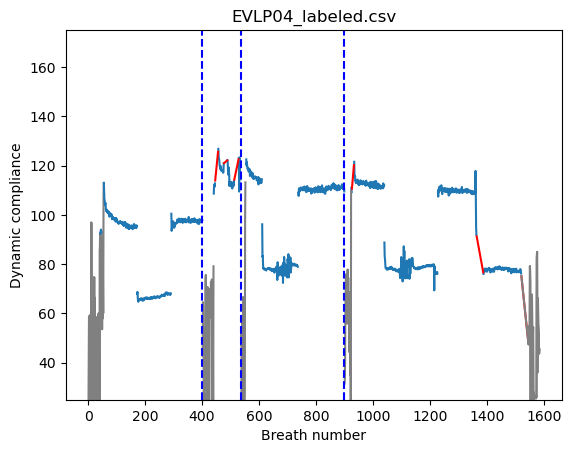

In [3]:
all_labels = {
    "Assessment",
    "Bronch",
    "Deflation",
    "InPause",
    "Noise",
    "Normal",
    "Question",
    "Recruitment",
    "Unvisited",
}

for csv_file in ["EVLP04_labeled.csv"]:
    # ["EVLP04_labeled.csv", "20191212_EVLP619_labeled.csv", "20210403_EVLP735_labeled.csv", "20210410_EVLP738_labeled.csv"]:
    df = pd.read_csv(os.path.join(LABELED_DATA_DIR, csv_file))
    plt.figure()
    plt.title(csv_file)
    plt.ylim(25, 175)
    t_start = None
    t_end = None
    colors = {
        "Interpolate": "red",
        "Assessment": "#1f77b4",
        "Normal": "#1f77b4",
    }
    if "Duration(s)" in df.columns:
        x_data = np.cumsum(df["Duration(s)"].to_numpy())
        x_label = "Time (s)"
    else:
        x_data = df["Breath_num"]
        x_label = "Breath number"
    plt.xlabel(x_label)
    plt.ylabel("Dynamic compliance")
    Dy_comp = df["Dy_comp"].to_numpy()

    # note there are some normal index before 55, not sure what to do with them, ignore them for better-looking plot for now

    plt.plot(x_data[t_start:55], Dy_comp[t_start:55], c="grey")

    label_normal_index = list(df["Label"][df["Label"] == "Normal"].index)

    for i, index in enumerate(label_normal_index):
        if index <= 55 or index >= 1520 or i == len(label_normal_index) - 1:
            # for demo
            continue
        label_index_next = label_normal_index[i + 1]
        if index == label_index_next - 1:
            continue
        # print(index, label_index_next)
        # skip if there is an assessment / bronch label
        if (df["Label"][index + 1 : label_index_next] == "Assessment").any() or (
            df["Label"][index + 1 : label_index_next] == "Bronch"
        ).any():
            continue
        # linear interpolate
        start = df["Dy_comp"][index]
        end = df["Dy_comp"][label_index_next]
        print(f"interpolate between {index+1}: {start} and {label_index_next-1}: {end}")
        # print(start, end)
        diff = (end - start) / (label_index_next - index)
        for j in range(index + 1, label_index_next):
            df["Dy_comp"][j] = df["Dy_comp"][j - 1] + diff
            df["Label"][j] = "Interpolate"
            # TODO: do not change label in real preprocessing

    label_assessment_index = list(df["Label"][df["Label"] == "Assessment"].index)

    for i, index in enumerate(label_assessment_index):
        if index <= 55 or index >= 1520 or i == len(label_assessment_index) - 1:
            continue
        label_index_next = label_assessment_index[i + 1]
        if index == label_index_next - 1:
            continue
        if (df["Label"][index + 1 : label_index_next] == "normal").any() or (
            df["Label"][index + 1 : label_index_next] == "Bronch"
        ).any():
            continue
        start = df["Dy_comp"][index]
        end = df["Dy_comp"][label_index_next]
        print(f"interpolate between {index} and {label_index_next}")
        diff = (end - start) / (label_index_next - index)
        for j in range(index + 1, label_index_next):
            df["Dy_comp"][j] = df["Dy_comp"][j - 1] + diff
            df["Label"][j] = "Interpolate"

    all_labels.add("Interpolate")

    # plt.plot(
    #     x_data[55:1520],
    #     Dy_comp[55:1520],
    # )

    # for label in ["Interpolate"]:
    #     Dy_comp_sub = Dy_comp.copy()
    #     Dy_comp_sub[df['Label'] != label] = float('nan')
    #     plt.plot(
    #         x_data[55:1520],
    #         Dy_comp_sub[55:1520],
    #         c="red" if label == "Interpolate" else "#1f77b4",
    #     )

    df["Label"][1121] = "Noise"

    for label in all_labels:
        Dy_comp_sub = Dy_comp.copy()
        Dy_comp_sub[df["Label"] != label] = float("nan")
        plt.plot(
            x_data[t_start:t_end],
            Dy_comp_sub[t_start:t_end],
            c=colors.get(label, "grey"),
        )

    label_bronch_index = list(df["Label"][df["Label"] == "Bronch"].index)

    for i, index in enumerate(label_bronch_index):
        if (
            index > 55
            and index < 1520
            and i < len(label_bronch_index) - 1
            and index != label_bronch_index[i - 1] + 1
        ):
            plt.axvline(x=index, color="b", linestyle="dashed")

    # note there is a singleton normal label at 1546, probably need to filter it out as a corner case

    plt.plot(x_data[1520:t_end], Dy_comp[1520:t_end], c="grey")

    # last pass: calculate std for consecutive lavel to find outliers

    # plt.savefig("1.png", transparent=True)